# 1. Libraries

In [27]:
# !pip install sklearn
# !pip install fancyimpute
# !pip install missingpy

In [28]:
import sklearn
print(sklearn.__version__)


1.2.2


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import Dataset, DataLoader
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from fancyimpute import IterativeImputer as MICE
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import learning_curve


In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.model_selection import learning_curve

In [31]:
from sklearn.inspection import permutation_importance

In [38]:
all_train_losses = {}
all_val_losses = {}
all_train_accuracies = {}
all_val_accuracies = {}
epochsx = 20
# create a dictionary to store all the metrics
all_val_metrics = {
    'confusion_matrix': {},
    'classification_report': {}
}

In [39]:
from util.functions import snap_dataframe
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from fancyimpute import IterativeImputer as MICE
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import learning_curve

imputation_methods = {
    'mean': SimpleImputer(strategy='mean'),
    'median': SimpleImputer(strategy='median'),
    'mode': SimpleImputer(strategy='most_frequent'),
    'KNN': KNNImputer(n_neighbors=2),
    'MICE': MICE(),
    'iterative': IterativeImputer(random_state=0),
}
models = {method: [] for method in imputation_methods}
metrics = {
    'accuracies': {method: [] for method in imputation_methods},
    'precisions': {method: [] for method in imputation_methods},
    'recalls': {method: [] for method in imputation_methods},
    'f1_scores': {method: [] for method in imputation_methods},
}
confusion_matrices = {method: [] for method in imputation_methods}

learning_curves = {method: [] for method in imputation_methods}
dataframes = {method: [] for method in imputation_methods}
# feature_importances = {}

dataframe = pd.read_csv('processed/df_numeric.csv')

for (impute_name, imputer) in imputation_methods.items():
    print(f'learning with {impute_name} imputed data')

    # Define the number of desired cross-validation iterations
    num_cv_iterations = 5

    # Perform cross-validation iterations
    for i in range(num_cv_iterations):
        print('cv iteration {}/{}'.format(i + 1, num_cv_iterations))

        # Split the data into training and test sets
        train, test_1 = train_test_split(
            dataframe, test_size=0.2, random_state=42)

        # Perform imputation on the training set
        train_imputed = pd.DataFrame(train, columns=dataframe.columns)
        train_imputed[train_imputed.columns] = imputer.fit_transform(
            train)
        train_imputed = snap_dataframe(pd.DataFrame(train_imputed))

        # Drop NaN values from the test set
        test_dropped = test_1.dropna()

        # Train the model on the imputed training set
        ##############################
        
        val, test = train_test_split(test_dropped, test_size=0.5, random_state=42)

        class CKDDataset(Dataset):
            def __init__(self, data):
                self.data = torch.tensor(data.drop(columns='class').values, dtype=torch.float32)
                self.targets = torch.tensor(data['class'].values, dtype=torch.long)

            def __len__(self):
                return len(self.data)

            def __getitem__(self, idx):
                return self.data[idx], self.targets[idx]

        train_dataset = CKDDataset(train_imputed)
        train_loader = DataLoader(train_dataset, batch_size=16)

        val_dataset = CKDDataset(val)
        val_loader = DataLoader(val_dataset, batch_size=16)

        test_dataset = CKDDataset(test)
        test_loader = DataLoader(test_dataset, batch_size=16)

        # Define the network architecture
        class Net(nn.Module):
            def __init__(self):
                super(Net, self).__init__()

                self.fc1 = nn.Linear(24, 32)
                self.fc2 = nn.Linear(32, 16)
                self.fc3 = nn.Linear(16, 2)
                self.dropout = nn.Dropout(0.2) # 20% dropout rate

            def forward(self, x):
                x = nn.functional.relu(self.fc1(x))
                x = self.dropout(x)
                x = nn.functional.relu(self.fc2(x))
                x = self.dropout(x)
                x = nn.functional.log_softmax(self.fc3(x), dim=1)
                return x

        # Initialize the network and define the loss function and optimizer
        model = Net()
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # Train the model
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []

        for epoch in range(epochsx):
            model.train()
            train_loss = 0.0
            correct = total = 0
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(True):
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    loss.backward()
                    optimizer.step()

                    train_loss += loss.item()
                    _, predicted = outputs.max(1)
                    total += targets.size(0)
                    correct += predicted.eq(targets).sum().item()

            train_acc = correct / total
            train_accuracies.append(train_acc)
            train_loss /= len(train_loader)
            train_losses.append(train_loss)

            # Validation phase
            model.eval()
            val_loss = 0.0
            correct_val = total_val = 0
            val_preds = []
            with torch.no_grad():
                for inputs, targets in val_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    val_loss += loss.item()
                    _, predicted = outputs.max(1)
                    val_preds.extend(predicted.tolist())
                    total_val += targets.size(0)
                    correct_val += predicted.eq(targets).sum()


            val_acc = correct_val / total_val
            val_loss /= len(val_loader)

            # Calculate confusion matrix and classification report
            cm = confusion_matrix(val['class'], np.array(val_preds))
            cr = classification_report(val['class'], np.array(val_preds), output_dict=True)

            all_val_metrics['confusion_matrix'][impute_name] = cm
            all_val_metrics['classification_report'][impute_name] = cr

            print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.3f}, Val Loss: {val_loss:.3f}, Train Acc: {train_acc:.3f}, Val Acc: {val_acc:.3f}')

        all_train_losses[impute_name] = train_losses
        all_val_losses[impute_name] = val_losses
        all_train_accuracies[impute_name] = train_accuracies
        all_val_accuracies[impute_name] = val_accuracies


learning with mean imputed data
cv iteration 1/5
Epoch: 1, Train Loss: 71.994, Val Loss: 56.584, Train Acc: 0.527, Val Acc: 0.500
Epoch: 2, Train Loss: 35.128, Val Loss: 1.665, Train Acc: 0.642, Val Acc: 0.500
Epoch: 3, Train Loss: 25.835, Val Loss: 7.147, Train Acc: 0.484, Val Acc: 0.500
Epoch: 4, Train Loss: 15.249, Val Loss: 0.703, Train Acc: 0.616, Val Acc: 0.700
Epoch: 5, Train Loss: 9.835, Val Loss: 2.779, Train Acc: 0.591, Val Acc: 0.500
Epoch: 6, Train Loss: 8.510, Val Loss: 0.685, Train Acc: 0.570, Val Acc: 0.500
Epoch: 7, Train Loss: 4.798, Val Loss: 0.897, Train Acc: 0.595, Val Acc: 0.500
Epoch: 8, Train Loss: 4.047, Val Loss: 0.682, Train Acc: 0.588, Val Acc: 0.500
Epoch: 9, Train Loss: 2.452, Val Loss: 0.711, Train Acc: 0.613, Val Acc: 0.500
Epoch: 10, Train Loss: 2.651, Val Loss: 0.690, Train Acc: 0.552, Val Acc: 0.500
Epoch: 11, Train Loss: 1.243, Val Loss: 0.864, Train Acc: 0.627, Val Acc: 0.500
Epoch: 12, Train Loss: 1.665, Val Loss: 0.776, Train Acc: 0.631, Val Acc: 0

/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

Epoch: 19, Train Loss: 1.309, Val Loss: 0.769, Train Acc: 0.620, Val Acc: 0.500
Epoch: 20, Train Loss: 0.696, Val Loss: 0.759, Train Acc: 0.692, Val Acc: 0.500
cv iteration 2/5
Epoch: 1, Train Loss: 32.184, Val Loss: 28.435, Train Acc: 0.595, Val Acc: 0.500
Epoch: 2, Train Loss: 17.053, Val Loss: 4.342, Train Acc: 0.652, Val Acc: 0.500
Epoch: 3, Train Loss: 11.649, Val Loss: 2.819, Train Acc: 0.559, Val Acc: 0.500
Epoch: 4, Train Loss: 10.663, Val Loss: 3.163, Train Acc: 0.588, Val Acc: 0.500
Epoch: 5, Train Loss: 6.580, Val Loss: 0.925, Train Acc: 0.530, Val Acc: 0.500
Epoch: 6, Train Loss: 3.723, Val Loss: 1.000, Train Acc: 0.634, Val Acc: 0.500
Epoch: 7, Train Loss: 3.991, Val Loss: 0.700, Train Acc: 0.556, Val Acc: 0.500
Epoch: 8, Train Loss: 2.833, Val Loss: 0.691, Train Acc: 0.602, Val Acc: 0.600
Epoch: 9, Train Loss: 1.981, Val Loss: 0.697, Train Acc: 0.616, Val Acc: 0.500
Epoch: 10, Train Loss: 1.377, Val Loss: 0.704, Train Acc: 0.645, Val Acc: 0.500
Epoch: 11, Train Loss: 1.28

/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

Epoch: 18, Train Loss: 0.777, Val Loss: 0.716, Train Acc: 0.624, Val Acc: 0.500
Epoch: 19, Train Loss: 0.923, Val Loss: 0.753, Train Acc: 0.631, Val Acc: 0.500
Epoch: 20, Train Loss: 1.017, Val Loss: 0.749, Train Acc: 0.642, Val Acc: 0.500
cv iteration 3/5
Epoch: 1, Train Loss: 84.538, Val Loss: 64.564, Train Acc: 0.462, Val Acc: 0.500
Epoch: 2, Train Loss: 44.713, Val Loss: 39.172, Train Acc: 0.634, Val Acc: 0.500
Epoch: 3, Train Loss: 39.067, Val Loss: 27.643, Train Acc: 0.581, Val Acc: 0.500
Epoch: 4, Train Loss: 27.781, Val Loss: 17.415, Train Acc: 0.606, Val Acc: 0.500
Epoch: 5, Train Loss: 22.369, Val Loss: 17.252, Train Acc: 0.588, Val Acc: 0.500
Epoch: 6, Train Loss: 14.362, Val Loss: 13.803, Train Acc: 0.616, Val Acc: 0.500
Epoch: 7, Train Loss: 12.900, Val Loss: 8.977, Train Acc: 0.588, Val Acc: 0.500
Epoch: 8, Train Loss: 7.757, Val Loss: 3.216, Train Acc: 0.616, Val Acc: 0.500
Epoch: 9, Train Loss: 6.200, Val Loss: 1.759, Train Acc: 0.599, Val Acc: 0.500
Epoch: 10, Train Lo

/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

Epoch: 17, Train Loss: 1.347, Val Loss: 0.704, Train Acc: 0.692, Val Acc: 0.500
Epoch: 18, Train Loss: 0.948, Val Loss: 0.723, Train Acc: 0.703, Val Acc: 0.500
Epoch: 19, Train Loss: 1.228, Val Loss: 0.752, Train Acc: 0.695, Val Acc: 0.500
Epoch: 20, Train Loss: 0.886, Val Loss: 0.810, Train Acc: 0.685, Val Acc: 0.500
cv iteration 4/5
Epoch: 1, Train Loss: 20.874, Val Loss: 24.451, Train Acc: 0.527, Val Acc: 0.500
Epoch: 2, Train Loss: 16.147, Val Loss: 5.075, Train Acc: 0.613, Val Acc: 0.500
Epoch: 3, Train Loss: 9.539, Val Loss: 1.758, Train Acc: 0.563, Val Acc: 0.500
Epoch: 4, Train Loss: 6.447, Val Loss: 2.051, Train Acc: 0.552, Val Acc: 0.500
Epoch: 5, Train Loss: 6.060, Val Loss: 1.851, Train Acc: 0.573, Val Acc: 0.500
Epoch: 6, Train Loss: 4.103, Val Loss: 1.622, Train Acc: 0.573, Val Acc: 0.500
Epoch: 7, Train Loss: 4.239, Val Loss: 1.454, Train Acc: 0.516, Val Acc: 0.500
Epoch: 8, Train Loss: 2.731, Val Loss: 1.279, Train Acc: 0.588, Val Acc: 0.500
Epoch: 9, Train Loss: 2.020,

/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

Epoch: 12, Train Loss: 1.222, Val Loss: 0.730, Train Acc: 0.642, Val Acc: 0.500
Epoch: 13, Train Loss: 1.211, Val Loss: 0.708, Train Acc: 0.674, Val Acc: 0.500
Epoch: 14, Train Loss: 1.238, Val Loss: 0.754, Train Acc: 0.606, Val Acc: 0.500
Epoch: 15, Train Loss: 0.954, Val Loss: 0.729, Train Acc: 0.659, Val Acc: 0.500
Epoch: 16, Train Loss: 0.939, Val Loss: 0.745, Train Acc: 0.645, Val Acc: 0.500
Epoch: 17, Train Loss: 0.976, Val Loss: 0.756, Train Acc: 0.642, Val Acc: 0.500
Epoch: 18, Train Loss: 0.684, Val Loss: 0.743, Train Acc: 0.685, Val Acc: 0.500
Epoch: 19, Train Loss: 0.830, Val Loss: 0.712, Train Acc: 0.645, Val Acc: 0.500
Epoch: 20, Train Loss: 0.778, Val Loss: 0.737, Train Acc: 0.710, Val Acc: 0.500
cv iteration 5/5
Epoch: 1, Train Loss: 68.445, Val Loss: 43.118, Train Acc: 0.624, Val Acc: 0.500
Epoch: 2, Train Loss: 48.571, Val Loss: 42.442, Train Acc: 0.581, Val Acc: 0.500
Epoch: 3, Train Loss: 32.488, Val Loss: 19.016, Train Acc: 0.602, Val Acc: 0.500
Epoch: 4, Train Loss

/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

Epoch: 11, Train Loss: 3.703, Val Loss: 0.812, Train Acc: 0.613, Val Acc: 0.500
Epoch: 12, Train Loss: 2.957, Val Loss: 0.697, Train Acc: 0.609, Val Acc: 0.400
Epoch: 13, Train Loss: 2.436, Val Loss: 0.681, Train Acc: 0.588, Val Acc: 0.400
Epoch: 14, Train Loss: 2.154, Val Loss: 0.684, Train Acc: 0.667, Val Acc: 0.400
Epoch: 15, Train Loss: 2.120, Val Loss: 0.684, Train Acc: 0.627, Val Acc: 0.400
Epoch: 16, Train Loss: 1.357, Val Loss: 0.717, Train Acc: 0.563, Val Acc: 0.500
Epoch: 17, Train Loss: 1.786, Val Loss: 0.708, Train Acc: 0.652, Val Acc: 0.500
Epoch: 18, Train Loss: 1.741, Val Loss: 0.691, Train Acc: 0.606, Val Acc: 0.400
Epoch: 19, Train Loss: 1.532, Val Loss: 0.690, Train Acc: 0.563, Val Acc: 0.400
Epoch: 20, Train Loss: 1.149, Val Loss: 0.693, Train Acc: 0.638, Val Acc: 0.400
learning with median imputed data
cv iteration 1/5
Epoch: 1, Train Loss: 42.449, Val Loss: 38.850, Train Acc: 0.609, Val Acc: 0.500
Epoch: 2, Train Loss: 36.300, Val Loss: 22.781, Train Acc: 0.566, Va

/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

Epoch: 9, Train Loss: 2.743, Val Loss: 0.878, Train Acc: 0.620, Val Acc: 0.500
Epoch: 10, Train Loss: 2.707, Val Loss: 0.689, Train Acc: 0.624, Val Acc: 0.500
Epoch: 11, Train Loss: 2.095, Val Loss: 0.704, Train Acc: 0.645, Val Acc: 0.500
Epoch: 12, Train Loss: 1.520, Val Loss: 0.771, Train Acc: 0.692, Val Acc: 0.500
Epoch: 13, Train Loss: 1.494, Val Loss: 0.723, Train Acc: 0.703, Val Acc: 0.500
Epoch: 14, Train Loss: 1.262, Val Loss: 0.702, Train Acc: 0.685, Val Acc: 0.500
Epoch: 15, Train Loss: 1.377, Val Loss: 0.759, Train Acc: 0.677, Val Acc: 0.500
Epoch: 16, Train Loss: 1.106, Val Loss: 0.694, Train Acc: 0.695, Val Acc: 0.500
Epoch: 17, Train Loss: 0.971, Val Loss: 0.740, Train Acc: 0.685, Val Acc: 0.500
Epoch: 18, Train Loss: 1.048, Val Loss: 0.699, Train Acc: 0.706, Val Acc: 0.500
Epoch: 19, Train Loss: 0.784, Val Loss: 0.714, Train Acc: 0.706, Val Acc: 0.500
Epoch: 20, Train Loss: 1.203, Val Loss: 0.738, Train Acc: 0.695, Val Acc: 0.500
cv iteration 2/5
Epoch: 1, Train Loss: 11

/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

Epoch: 8, Train Loss: 8.886, Val Loss: 0.970, Train Acc: 0.602, Val Acc: 0.500
Epoch: 9, Train Loss: 9.437, Val Loss: 0.632, Train Acc: 0.538, Val Acc: 0.600
Epoch: 10, Train Loss: 6.182, Val Loss: 0.740, Train Acc: 0.616, Val Acc: 0.500
Epoch: 11, Train Loss: 5.378, Val Loss: 0.770, Train Acc: 0.602, Val Acc: 0.500
Epoch: 12, Train Loss: 4.267, Val Loss: 0.666, Train Acc: 0.548, Val Acc: 0.600
Epoch: 13, Train Loss: 3.453, Val Loss: 0.667, Train Acc: 0.548, Val Acc: 0.500
Epoch: 14, Train Loss: 2.667, Val Loss: 0.772, Train Acc: 0.588, Val Acc: 0.500
Epoch: 15, Train Loss: 2.527, Val Loss: 0.681, Train Acc: 0.613, Val Acc: 0.500
Epoch: 16, Train Loss: 1.963, Val Loss: 0.686, Train Acc: 0.563, Val Acc: 0.400
Epoch: 17, Train Loss: 1.802, Val Loss: 0.681, Train Acc: 0.620, Val Acc: 0.600
Epoch: 18, Train Loss: 1.142, Val Loss: 0.708, Train Acc: 0.541, Val Acc: 0.500
Epoch: 19, Train Loss: 1.457, Val Loss: 0.679, Train Acc: 0.609, Val Acc: 0.500
Epoch: 20, Train Loss: 0.934, Val Loss: 0.

/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

Epoch: 7, Train Loss: 1.362, Val Loss: 0.746, Train Acc: 0.710, Val Acc: 0.500
Epoch: 8, Train Loss: 1.211, Val Loss: 0.738, Train Acc: 0.692, Val Acc: 0.500
Epoch: 9, Train Loss: 1.103, Val Loss: 0.771, Train Acc: 0.685, Val Acc: 0.500
Epoch: 10, Train Loss: 0.916, Val Loss: 0.705, Train Acc: 0.699, Val Acc: 0.500
Epoch: 11, Train Loss: 1.190, Val Loss: 0.715, Train Acc: 0.706, Val Acc: 0.500
Epoch: 12, Train Loss: 0.824, Val Loss: 0.741, Train Acc: 0.685, Val Acc: 0.500
Epoch: 13, Train Loss: 0.832, Val Loss: 0.723, Train Acc: 0.699, Val Acc: 0.500
Epoch: 14, Train Loss: 0.962, Val Loss: 0.708, Train Acc: 0.695, Val Acc: 0.500
Epoch: 15, Train Loss: 1.062, Val Loss: 0.725, Train Acc: 0.699, Val Acc: 0.500
Epoch: 16, Train Loss: 0.828, Val Loss: 0.702, Train Acc: 0.699, Val Acc: 0.500
Epoch: 17, Train Loss: 0.789, Val Loss: 0.711, Train Acc: 0.703, Val Acc: 0.500
Epoch: 18, Train Loss: 0.621, Val Loss: 0.707, Train Acc: 0.706, Val Acc: 0.500
Epoch: 19, Train Loss: 1.378, Val Loss: 0.7

/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

Epoch: 6, Train Loss: 13.460, Val Loss: 1.111, Train Acc: 0.548, Val Acc: 0.500
Epoch: 7, Train Loss: 10.381, Val Loss: 2.130, Train Acc: 0.613, Val Acc: 0.500
Epoch: 8, Train Loss: 8.026, Val Loss: 0.777, Train Acc: 0.570, Val Acc: 0.500
Epoch: 9, Train Loss: 6.703, Val Loss: 0.822, Train Acc: 0.606, Val Acc: 0.500
Epoch: 10, Train Loss: 3.620, Val Loss: 1.024, Train Acc: 0.606, Val Acc: 0.500
Epoch: 11, Train Loss: 3.717, Val Loss: 0.862, Train Acc: 0.599, Val Acc: 0.500
Epoch: 12, Train Loss: 3.500, Val Loss: 0.755, Train Acc: 0.599, Val Acc: 0.500
Epoch: 13, Train Loss: 2.974, Val Loss: 0.711, Train Acc: 0.616, Val Acc: 0.500
Epoch: 14, Train Loss: 3.478, Val Loss: 0.713, Train Acc: 0.606, Val Acc: 0.500
Epoch: 15, Train Loss: 2.152, Val Loss: 0.718, Train Acc: 0.595, Val Acc: 0.500
Epoch: 16, Train Loss: 2.047, Val Loss: 0.721, Train Acc: 0.670, Val Acc: 0.500
Epoch: 17, Train Loss: 1.828, Val Loss: 0.709, Train Acc: 0.688, Val Acc: 0.500
Epoch: 18, Train Loss: 1.785, Val Loss: 0.

/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

Epoch: 5, Train Loss: 11.048, Val Loss: 0.651, Train Acc: 0.609, Val Acc: 0.500
Epoch: 6, Train Loss: 7.751, Val Loss: 1.495, Train Acc: 0.552, Val Acc: 0.500
Epoch: 7, Train Loss: 4.499, Val Loss: 0.753, Train Acc: 0.588, Val Acc: 0.500
Epoch: 8, Train Loss: 3.118, Val Loss: 0.712, Train Acc: 0.674, Val Acc: 0.500
Epoch: 9, Train Loss: 3.052, Val Loss: 0.818, Train Acc: 0.659, Val Acc: 0.500
Epoch: 10, Train Loss: 2.239, Val Loss: 0.844, Train Acc: 0.631, Val Acc: 0.500
Epoch: 11, Train Loss: 1.843, Val Loss: 0.746, Train Acc: 0.670, Val Acc: 0.500
Epoch: 12, Train Loss: 1.142, Val Loss: 0.748, Train Acc: 0.677, Val Acc: 0.500
Epoch: 13, Train Loss: 1.121, Val Loss: 0.729, Train Acc: 0.652, Val Acc: 0.500
Epoch: 14, Train Loss: 1.220, Val Loss: 0.737, Train Acc: 0.674, Val Acc: 0.500
Epoch: 15, Train Loss: 1.087, Val Loss: 0.927, Train Acc: 0.663, Val Acc: 0.500
Epoch: 16, Train Loss: 1.333, Val Loss: 0.888, Train Acc: 0.659, Val Acc: 0.500
Epoch: 17, Train Loss: 1.160, Val Loss: 0.89

/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

Epoch: 3, Train Loss: 42.633, Val Loss: 32.113, Train Acc: 0.634, Val Acc: 0.500
Epoch: 4, Train Loss: 33.414, Val Loss: 28.270, Train Acc: 0.613, Val Acc: 0.500
Epoch: 5, Train Loss: 28.456, Val Loss: 16.228, Train Acc: 0.581, Val Acc: 0.500
Epoch: 6, Train Loss: 15.871, Val Loss: 10.017, Train Acc: 0.566, Val Acc: 0.500
Epoch: 7, Train Loss: 13.396, Val Loss: 7.230, Train Acc: 0.577, Val Acc: 0.500
Epoch: 8, Train Loss: 10.393, Val Loss: 2.602, Train Acc: 0.599, Val Acc: 0.500
Epoch: 9, Train Loss: 7.121, Val Loss: 1.605, Train Acc: 0.649, Val Acc: 0.500
Epoch: 10, Train Loss: 7.340, Val Loss: 1.180, Train Acc: 0.613, Val Acc: 0.400
Epoch: 11, Train Loss: 4.431, Val Loss: 0.838, Train Acc: 0.613, Val Acc: 0.400
Epoch: 12, Train Loss: 4.811, Val Loss: 0.799, Train Acc: 0.634, Val Acc: 0.400
Epoch: 13, Train Loss: 3.636, Val Loss: 0.701, Train Acc: 0.602, Val Acc: 0.400
Epoch: 14, Train Loss: 2.965, Val Loss: 0.739, Train Acc: 0.634, Val Acc: 0.500


/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

Epoch: 15, Train Loss: 2.037, Val Loss: 0.686, Train Acc: 0.634, Val Acc: 0.500
Epoch: 16, Train Loss: 3.038, Val Loss: 0.687, Train Acc: 0.577, Val Acc: 0.500
Epoch: 17, Train Loss: 1.844, Val Loss: 0.741, Train Acc: 0.581, Val Acc: 0.500
Epoch: 18, Train Loss: 1.561, Val Loss: 0.717, Train Acc: 0.667, Val Acc: 0.500
Epoch: 19, Train Loss: 1.265, Val Loss: 0.720, Train Acc: 0.595, Val Acc: 0.500
Epoch: 20, Train Loss: 1.376, Val Loss: 0.681, Train Acc: 0.638, Val Acc: 0.500
cv iteration 2/5
Epoch: 1, Train Loss: 251.000, Val Loss: 83.972, Train Acc: 0.294, Val Acc: 0.500
Epoch: 2, Train Loss: 84.985, Val Loss: 10.153, Train Acc: 0.308, Val Acc: 0.500
Epoch: 3, Train Loss: 16.919, Val Loss: 7.371, Train Acc: 0.459, Val Acc: 0.500
Epoch: 4, Train Loss: 6.925, Val Loss: 4.262, Train Acc: 0.638, Val Acc: 0.500
Epoch: 5, Train Loss: 5.456, Val Loss: 0.752, Train Acc: 0.559, Val Acc: 0.500
Epoch: 6, Train Loss: 4.445, Val Loss: 1.404, Train Acc: 0.538, Val Acc: 0.500
Epoch: 7, Train Loss: 2

/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

Epoch: 13, Train Loss: 1.079, Val Loss: 0.966, Train Acc: 0.688, Val Acc: 0.500
Epoch: 14, Train Loss: 1.677, Val Loss: 0.798, Train Acc: 0.631, Val Acc: 0.500
Epoch: 15, Train Loss: 0.872, Val Loss: 0.756, Train Acc: 0.695, Val Acc: 0.500
Epoch: 16, Train Loss: 0.823, Val Loss: 0.748, Train Acc: 0.699, Val Acc: 0.500
Epoch: 17, Train Loss: 1.102, Val Loss: 0.716, Train Acc: 0.670, Val Acc: 0.500
Epoch: 18, Train Loss: 1.594, Val Loss: 0.828, Train Acc: 0.695, Val Acc: 0.500
Epoch: 19, Train Loss: 0.828, Val Loss: 0.780, Train Acc: 0.692, Val Acc: 0.500
Epoch: 20, Train Loss: 0.731, Val Loss: 0.854, Train Acc: 0.706, Val Acc: 0.500
cv iteration 3/5
Epoch: 1, Train Loss: 32.886, Val Loss: 20.158, Train Acc: 0.631, Val Acc: 0.500
Epoch: 2, Train Loss: 21.706, Val Loss: 14.788, Train Acc: 0.609, Val Acc: 0.500
Epoch: 3, Train Loss: 14.617, Val Loss: 14.449, Train Acc: 0.606, Val Acc: 0.500
Epoch: 4, Train Loss: 12.876, Val Loss: 8.169, Train Acc: 0.599, Val Acc: 0.500
Epoch: 5, Train Loss

/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

Epoch: 12, Train Loss: 2.244, Val Loss: 0.687, Train Acc: 0.552, Val Acc: 0.600
Epoch: 13, Train Loss: 2.224, Val Loss: 0.680, Train Acc: 0.523, Val Acc: 0.600
Epoch: 14, Train Loss: 1.207, Val Loss: 0.680, Train Acc: 0.588, Val Acc: 0.400
Epoch: 15, Train Loss: 1.138, Val Loss: 0.680, Train Acc: 0.559, Val Acc: 0.400
Epoch: 16, Train Loss: 1.064, Val Loss: 0.683, Train Acc: 0.520, Val Acc: 0.500
Epoch: 17, Train Loss: 0.964, Val Loss: 0.683, Train Acc: 0.606, Val Acc: 0.400
Epoch: 18, Train Loss: 1.167, Val Loss: 0.683, Train Acc: 0.523, Val Acc: 0.500
Epoch: 19, Train Loss: 1.130, Val Loss: 0.690, Train Acc: 0.570, Val Acc: 0.500
Epoch: 20, Train Loss: 0.952, Val Loss: 0.686, Train Acc: 0.498, Val Acc: 0.500
cv iteration 4/5
Epoch: 1, Train Loss: 60.008, Val Loss: 2.113, Train Acc: 0.652, Val Acc: 0.500
Epoch: 2, Train Loss: 43.429, Val Loss: 16.793, Train Acc: 0.566, Val Acc: 0.500
Epoch: 3, Train Loss: 30.598, Val Loss: 3.611, Train Acc: 0.609, Val Acc: 0.500
Epoch: 4, Train Loss: 

/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

Epoch: 7, Train Loss: 9.141, Val Loss: 0.972, Train Acc: 0.588, Val Acc: 0.400
Epoch: 8, Train Loss: 4.581, Val Loss: 1.299, Train Acc: 0.591, Val Acc: 0.500
Epoch: 9, Train Loss: 4.257, Val Loss: 0.890, Train Acc: 0.631, Val Acc: 0.500
Epoch: 10, Train Loss: 2.622, Val Loss: 0.811, Train Acc: 0.584, Val Acc: 0.500
Epoch: 11, Train Loss: 2.796, Val Loss: 0.697, Train Acc: 0.645, Val Acc: 0.500
Epoch: 12, Train Loss: 1.823, Val Loss: 0.718, Train Acc: 0.677, Val Acc: 0.500
Epoch: 13, Train Loss: 1.574, Val Loss: 0.722, Train Acc: 0.659, Val Acc: 0.500
Epoch: 14, Train Loss: 1.481, Val Loss: 0.701, Train Acc: 0.659, Val Acc: 0.500
Epoch: 15, Train Loss: 1.497, Val Loss: 0.722, Train Acc: 0.681, Val Acc: 0.500
Epoch: 16, Train Loss: 1.066, Val Loss: 0.698, Train Acc: 0.703, Val Acc: 0.500
Epoch: 17, Train Loss: 0.874, Val Loss: 0.731, Train Acc: 0.670, Val Acc: 0.500
Epoch: 18, Train Loss: 0.888, Val Loss: 0.732, Train Acc: 0.695, Val Acc: 0.500
Epoch: 19, Train Loss: 1.040, Val Loss: 0.7

/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

Epoch: 3, Train Loss: 32.477, Val Loss: 33.670, Train Acc: 0.602, Val Acc: 0.500
Epoch: 4, Train Loss: 29.096, Val Loss: 12.093, Train Acc: 0.638, Val Acc: 0.500
Epoch: 5, Train Loss: 23.793, Val Loss: 11.047, Train Acc: 0.591, Val Acc: 0.500
Epoch: 6, Train Loss: 19.344, Val Loss: 5.437, Train Acc: 0.570, Val Acc: 0.500
Epoch: 7, Train Loss: 12.000, Val Loss: 2.522, Train Acc: 0.616, Val Acc: 0.500
Epoch: 8, Train Loss: 11.637, Val Loss: 3.079, Train Acc: 0.591, Val Acc: 0.500
Epoch: 9, Train Loss: 9.258, Val Loss: 3.777, Train Acc: 0.584, Val Acc: 0.500
Epoch: 10, Train Loss: 6.640, Val Loss: 1.574, Train Acc: 0.602, Val Acc: 0.500
Epoch: 11, Train Loss: 6.170, Val Loss: 0.806, Train Acc: 0.584, Val Acc: 0.500
Epoch: 12, Train Loss: 5.366, Val Loss: 1.379, Train Acc: 0.577, Val Acc: 0.500
Epoch: 13, Train Loss: 3.998, Val Loss: 1.640, Train Acc: 0.599, Val Acc: 0.500
Epoch: 14, Train Loss: 4.000, Val Loss: 0.805, Train Acc: 0.599, Val Acc: 0.500
Epoch: 15, Train Loss: 2.814, Val Loss

/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

Epoch: 17, Train Loss: 2.205, Val Loss: 0.750, Train Acc: 0.631, Val Acc: 0.500
Epoch: 18, Train Loss: 2.856, Val Loss: 0.808, Train Acc: 0.570, Val Acc: 0.500
Epoch: 19, Train Loss: 1.777, Val Loss: 0.879, Train Acc: 0.645, Val Acc: 0.500
Epoch: 20, Train Loss: 1.952, Val Loss: 0.737, Train Acc: 0.638, Val Acc: 0.500
learning with KNN imputed data
cv iteration 1/5
Epoch: 1, Train Loss: 66.385, Val Loss: 19.776, Train Acc: 0.552, Val Acc: 0.500


/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

Epoch: 2, Train Loss: 31.535, Val Loss: 26.805, Train Acc: 0.634, Val Acc: 0.500
Epoch: 3, Train Loss: 24.742, Val Loss: 19.695, Train Acc: 0.573, Val Acc: 0.500
Epoch: 4, Train Loss: 20.275, Val Loss: 4.876, Train Acc: 0.581, Val Acc: 0.500
Epoch: 5, Train Loss: 10.414, Val Loss: 1.852, Train Acc: 0.566, Val Acc: 0.500
Epoch: 6, Train Loss: 5.690, Val Loss: 1.453, Train Acc: 0.591, Val Acc: 0.500
Epoch: 7, Train Loss: 3.454, Val Loss: 0.694, Train Acc: 0.624, Val Acc: 0.500
Epoch: 8, Train Loss: 2.008, Val Loss: 0.708, Train Acc: 0.599, Val Acc: 0.500
Epoch: 9, Train Loss: 3.213, Val Loss: 0.763, Train Acc: 0.606, Val Acc: 0.500
Epoch: 10, Train Loss: 1.717, Val Loss: 0.692, Train Acc: 0.595, Val Acc: 0.500
Epoch: 11, Train Loss: 1.631, Val Loss: 0.731, Train Acc: 0.634, Val Acc: 0.500
Epoch: 12, Train Loss: 1.145, Val Loss: 0.792, Train Acc: 0.685, Val Acc: 0.500
Epoch: 13, Train Loss: 0.903, Val Loss: 0.699, Train Acc: 0.663, Val Acc: 0.600


/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

Epoch: 14, Train Loss: 1.098, Val Loss: 0.751, Train Acc: 0.652, Val Acc: 0.500
Epoch: 15, Train Loss: 0.997, Val Loss: 0.732, Train Acc: 0.677, Val Acc: 0.500
Epoch: 16, Train Loss: 1.141, Val Loss: 0.721, Train Acc: 0.670, Val Acc: 0.500
Epoch: 17, Train Loss: 1.166, Val Loss: 0.696, Train Acc: 0.638, Val Acc: 0.500
Epoch: 18, Train Loss: 1.025, Val Loss: 0.736, Train Acc: 0.674, Val Acc: 0.500
Epoch: 19, Train Loss: 0.933, Val Loss: 0.754, Train Acc: 0.620, Val Acc: 0.500
Epoch: 20, Train Loss: 0.823, Val Loss: 0.694, Train Acc: 0.692, Val Acc: 0.500
cv iteration 2/5
Epoch: 1, Train Loss: 61.533, Val Loss: 37.336, Train Acc: 0.530, Val Acc: 0.500


/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

Epoch: 2, Train Loss: 30.065, Val Loss: 9.649, Train Acc: 0.631, Val Acc: 0.500
Epoch: 3, Train Loss: 26.016, Val Loss: 16.975, Train Acc: 0.595, Val Acc: 0.500
Epoch: 4, Train Loss: 21.184, Val Loss: 2.796, Train Acc: 0.581, Val Acc: 0.500
Epoch: 5, Train Loss: 12.359, Val Loss: 1.728, Train Acc: 0.602, Val Acc: 0.500
Epoch: 6, Train Loss: 7.425, Val Loss: 1.275, Train Acc: 0.627, Val Acc: 0.500
Epoch: 7, Train Loss: 5.075, Val Loss: 0.762, Train Acc: 0.616, Val Acc: 0.500
Epoch: 8, Train Loss: 4.005, Val Loss: 0.800, Train Acc: 0.659, Val Acc: 0.500
Epoch: 9, Train Loss: 2.241, Val Loss: 0.693, Train Acc: 0.659, Val Acc: 0.500
Epoch: 10, Train Loss: 2.804, Val Loss: 0.704, Train Acc: 0.692, Val Acc: 0.500
Epoch: 11, Train Loss: 2.128, Val Loss: 0.749, Train Acc: 0.659, Val Acc: 0.500


/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

Epoch: 12, Train Loss: 1.547, Val Loss: 0.733, Train Acc: 0.681, Val Acc: 0.500
Epoch: 13, Train Loss: 1.052, Val Loss: 0.691, Train Acc: 0.642, Val Acc: 0.500
Epoch: 14, Train Loss: 0.906, Val Loss: 0.761, Train Acc: 0.659, Val Acc: 0.500
Epoch: 15, Train Loss: 1.431, Val Loss: 0.760, Train Acc: 0.685, Val Acc: 0.500
Epoch: 16, Train Loss: 0.958, Val Loss: 0.767, Train Acc: 0.692, Val Acc: 0.500
Epoch: 17, Train Loss: 0.802, Val Loss: 0.703, Train Acc: 0.692, Val Acc: 0.500
Epoch: 18, Train Loss: 0.787, Val Loss: 0.710, Train Acc: 0.692, Val Acc: 0.500
Epoch: 19, Train Loss: 1.389, Val Loss: 0.727, Train Acc: 0.699, Val Acc: 0.500
Epoch: 20, Train Loss: 1.090, Val Loss: 0.718, Train Acc: 0.674, Val Acc: 0.500
cv iteration 3/5
Epoch: 1, Train Loss: 254.937, Val Loss: 21.753, Train Acc: 0.355, Val Acc: 0.500


/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

Epoch: 2, Train Loss: 47.129, Val Loss: 70.629, Train Acc: 0.642, Val Acc: 0.500
Epoch: 3, Train Loss: 52.311, Val Loss: 30.244, Train Acc: 0.595, Val Acc: 0.500
Epoch: 4, Train Loss: 30.298, Val Loss: 7.541, Train Acc: 0.573, Val Acc: 0.500
Epoch: 5, Train Loss: 23.472, Val Loss: 10.909, Train Acc: 0.581, Val Acc: 0.500
Epoch: 6, Train Loss: 18.610, Val Loss: 7.159, Train Acc: 0.559, Val Acc: 0.500
Epoch: 7, Train Loss: 16.812, Val Loss: 5.154, Train Acc: 0.599, Val Acc: 0.500
Epoch: 8, Train Loss: 12.219, Val Loss: 0.670, Train Acc: 0.570, Val Acc: 0.700
Epoch: 9, Train Loss: 8.697, Val Loss: 1.455, Train Acc: 0.602, Val Acc: 0.500
Epoch: 10, Train Loss: 7.955, Val Loss: 1.158, Train Acc: 0.591, Val Acc: 0.500
Epoch: 11, Train Loss: 5.577, Val Loss: 0.826, Train Acc: 0.616, Val Acc: 0.500
Epoch: 12, Train Loss: 4.031, Val Loss: 1.480, Train Acc: 0.577, Val Acc: 0.500
Epoch: 13, Train Loss: 4.292, Val Loss: 0.883, Train Acc: 0.566, Val Acc: 0.500
Epoch: 14, Train Loss: 3.207, Val Loss

/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

Epoch: 15, Train Loss: 3.349, Val Loss: 0.899, Train Acc: 0.616, Val Acc: 0.500
Epoch: 16, Train Loss: 4.054, Val Loss: 0.835, Train Acc: 0.631, Val Acc: 0.500
Epoch: 17, Train Loss: 2.461, Val Loss: 0.868, Train Acc: 0.638, Val Acc: 0.500
Epoch: 18, Train Loss: 1.688, Val Loss: 1.018, Train Acc: 0.606, Val Acc: 0.500
Epoch: 19, Train Loss: 1.341, Val Loss: 0.811, Train Acc: 0.670, Val Acc: 0.500
Epoch: 20, Train Loss: 1.777, Val Loss: 0.785, Train Acc: 0.656, Val Acc: 0.500
cv iteration 4/5
Epoch: 1, Train Loss: 32.484, Val Loss: 12.124, Train Acc: 0.620, Val Acc: 0.500


/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

Epoch: 2, Train Loss: 25.948, Val Loss: 16.112, Train Acc: 0.588, Val Acc: 0.500
Epoch: 3, Train Loss: 17.225, Val Loss: 3.893, Train Acc: 0.599, Val Acc: 0.500
Epoch: 4, Train Loss: 11.855, Val Loss: 5.304, Train Acc: 0.599, Val Acc: 0.500
Epoch: 5, Train Loss: 12.488, Val Loss: 2.869, Train Acc: 0.520, Val Acc: 0.500
Epoch: 6, Train Loss: 8.006, Val Loss: 1.952, Train Acc: 0.602, Val Acc: 0.500
Epoch: 7, Train Loss: 7.415, Val Loss: 1.537, Train Acc: 0.595, Val Acc: 0.500
Epoch: 8, Train Loss: 7.750, Val Loss: 1.138, Train Acc: 0.534, Val Acc: 0.500
Epoch: 9, Train Loss: 5.004, Val Loss: 0.763, Train Acc: 0.591, Val Acc: 0.500
Epoch: 10, Train Loss: 3.760, Val Loss: 0.730, Train Acc: 0.616, Val Acc: 0.500
Epoch: 11, Train Loss: 4.251, Val Loss: 0.698, Train Acc: 0.556, Val Acc: 0.500


/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

Epoch: 12, Train Loss: 3.132, Val Loss: 0.763, Train Acc: 0.591, Val Acc: 0.500
Epoch: 13, Train Loss: 2.222, Val Loss: 0.813, Train Acc: 0.591, Val Acc: 0.500
Epoch: 14, Train Loss: 1.713, Val Loss: 0.700, Train Acc: 0.613, Val Acc: 0.500
Epoch: 15, Train Loss: 1.269, Val Loss: 0.734, Train Acc: 0.631, Val Acc: 0.500
Epoch: 16, Train Loss: 1.726, Val Loss: 0.717, Train Acc: 0.656, Val Acc: 0.500
Epoch: 17, Train Loss: 1.121, Val Loss: 0.710, Train Acc: 0.663, Val Acc: 0.500
Epoch: 18, Train Loss: 1.267, Val Loss: 0.739, Train Acc: 0.670, Val Acc: 0.500
Epoch: 19, Train Loss: 1.200, Val Loss: 0.792, Train Acc: 0.638, Val Acc: 0.500
Epoch: 20, Train Loss: 1.116, Val Loss: 0.728, Train Acc: 0.667, Val Acc: 0.500
cv iteration 5/5
Epoch: 1, Train Loss: 59.170, Val Loss: 31.340, Train Acc: 0.677, Val Acc: 0.500


/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

Epoch: 2, Train Loss: 32.335, Val Loss: 19.359, Train Acc: 0.573, Val Acc: 0.500
Epoch: 3, Train Loss: 19.126, Val Loss: 16.428, Train Acc: 0.645, Val Acc: 0.500
Epoch: 4, Train Loss: 17.507, Val Loss: 9.747, Train Acc: 0.523, Val Acc: 0.500
Epoch: 5, Train Loss: 12.362, Val Loss: 9.497, Train Acc: 0.602, Val Acc: 0.500
Epoch: 6, Train Loss: 11.095, Val Loss: 7.776, Train Acc: 0.588, Val Acc: 0.500
Epoch: 7, Train Loss: 7.131, Val Loss: 5.581, Train Acc: 0.634, Val Acc: 0.500
Epoch: 8, Train Loss: 4.762, Val Loss: 3.355, Train Acc: 0.599, Val Acc: 0.500
Epoch: 9, Train Loss: 4.301, Val Loss: 1.904, Train Acc: 0.642, Val Acc: 0.500
Epoch: 10, Train Loss: 3.411, Val Loss: 0.879, Train Acc: 0.620, Val Acc: 0.500


/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

Epoch: 11, Train Loss: 2.665, Val Loss: 0.976, Train Acc: 0.581, Val Acc: 0.500
Epoch: 12, Train Loss: 2.214, Val Loss: 0.758, Train Acc: 0.606, Val Acc: 0.500
Epoch: 13, Train Loss: 1.607, Val Loss: 0.713, Train Acc: 0.538, Val Acc: 0.500
Epoch: 14, Train Loss: 1.163, Val Loss: 0.719, Train Acc: 0.631, Val Acc: 0.500
Epoch: 15, Train Loss: 1.372, Val Loss: 0.704, Train Acc: 0.634, Val Acc: 0.500
Epoch: 16, Train Loss: 0.930, Val Loss: 0.720, Train Acc: 0.606, Val Acc: 0.500
Epoch: 17, Train Loss: 1.424, Val Loss: 0.722, Train Acc: 0.670, Val Acc: 0.500
Epoch: 18, Train Loss: 1.224, Val Loss: 0.705, Train Acc: 0.703, Val Acc: 0.500
Epoch: 19, Train Loss: 0.931, Val Loss: 0.703, Train Acc: 0.663, Val Acc: 0.500
Epoch: 20, Train Loss: 1.002, Val Loss: 0.733, Train Acc: 0.656, Val Acc: 0.500
learning with MICE imputed data
cv iteration 1/5
Epoch: 1, Train Loss: 42.383, Val Loss: 22.722, Train Acc: 0.591, Val Acc: 0.500


/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

Epoch: 2, Train Loss: 21.727, Val Loss: 7.842, Train Acc: 0.591, Val Acc: 0.500
Epoch: 3, Train Loss: 14.470, Val Loss: 2.284, Train Acc: 0.563, Val Acc: 0.500
Epoch: 4, Train Loss: 9.077, Val Loss: 0.809, Train Acc: 0.541, Val Acc: 0.500
Epoch: 5, Train Loss: 5.371, Val Loss: 0.830, Train Acc: 0.534, Val Acc: 0.500
Epoch: 6, Train Loss: 3.654, Val Loss: 0.697, Train Acc: 0.527, Val Acc: 0.500
Epoch: 7, Train Loss: 2.311, Val Loss: 0.697, Train Acc: 0.513, Val Acc: 0.500
Epoch: 8, Train Loss: 2.007, Val Loss: 0.696, Train Acc: 0.523, Val Acc: 0.500
Epoch: 9, Train Loss: 2.114, Val Loss: 0.695, Train Acc: 0.509, Val Acc: 0.500
Epoch: 10, Train Loss: 1.755, Val Loss: 0.695, Train Acc: 0.516, Val Acc: 0.500
Epoch: 11, Train Loss: 1.383, Val Loss: 0.694, Train Acc: 0.462, Val Acc: 0.500
Epoch: 12, Train Loss: 1.290, Val Loss: 0.689, Train Acc: 0.477, Val Acc: 0.400
Epoch: 13, Train Loss: 0.877, Val Loss: 0.690, Train Acc: 0.509, Val Acc: 0.400
Epoch: 14, Train Loss: 0.980, Val Loss: 0.689,

/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

Epoch: 16, Train Loss: 0.917, Val Loss: 0.695, Train Acc: 0.706, Val Acc: 0.500
Epoch: 17, Train Loss: 0.732, Val Loss: 0.693, Train Acc: 0.699, Val Acc: 0.500
Epoch: 18, Train Loss: 0.895, Val Loss: 0.698, Train Acc: 0.706, Val Acc: 0.500
Epoch: 19, Train Loss: 0.930, Val Loss: 0.694, Train Acc: 0.674, Val Acc: 0.500
Epoch: 20, Train Loss: 1.066, Val Loss: 0.695, Train Acc: 0.688, Val Acc: 0.500
cv iteration 2/5
Epoch: 1, Train Loss: 63.064, Val Loss: 56.716, Train Acc: 0.602, Val Acc: 0.500
Epoch: 2, Train Loss: 33.904, Val Loss: 25.103, Train Acc: 0.659, Val Acc: 0.500
Epoch: 3, Train Loss: 31.166, Val Loss: 19.761, Train Acc: 0.570, Val Acc: 0.500
Epoch: 4, Train Loss: 20.288, Val Loss: 9.352, Train Acc: 0.577, Val Acc: 0.500
Epoch: 5, Train Loss: 14.539, Val Loss: 2.758, Train Acc: 0.591, Val Acc: 0.500
Epoch: 6, Train Loss: 8.175, Val Loss: 1.347, Train Acc: 0.624, Val Acc: 0.500


/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

Epoch: 7, Train Loss: 7.147, Val Loss: 0.689, Train Acc: 0.656, Val Acc: 0.500
Epoch: 8, Train Loss: 5.614, Val Loss: 0.684, Train Acc: 0.599, Val Acc: 0.500
Epoch: 9, Train Loss: 4.396, Val Loss: 0.689, Train Acc: 0.502, Val Acc: 0.600
Epoch: 10, Train Loss: 2.424, Val Loss: 0.726, Train Acc: 0.609, Val Acc: 0.500
Epoch: 11, Train Loss: 2.208, Val Loss: 0.687, Train Acc: 0.455, Val Acc: 0.500
Epoch: 12, Train Loss: 2.152, Val Loss: 0.692, Train Acc: 0.581, Val Acc: 0.500
Epoch: 13, Train Loss: 1.816, Val Loss: 0.688, Train Acc: 0.538, Val Acc: 0.500
Epoch: 14, Train Loss: 1.384, Val Loss: 0.693, Train Acc: 0.559, Val Acc: 0.500
Epoch: 15, Train Loss: 0.774, Val Loss: 0.734, Train Acc: 0.645, Val Acc: 0.500
Epoch: 16, Train Loss: 1.351, Val Loss: 0.712, Train Acc: 0.620, Val Acc: 0.500
Epoch: 17, Train Loss: 1.385, Val Loss: 0.731, Train Acc: 0.677, Val Acc: 0.500
Epoch: 18, Train Loss: 1.070, Val Loss: 0.690, Train Acc: 0.695, Val Acc: 0.500
Epoch: 19, Train Loss: 1.205, Val Loss: 0.7

/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

Epoch: 1, Train Loss: 67.946, Val Loss: 27.733, Train Acc: 0.459, Val Acc: 0.500
Epoch: 2, Train Loss: 33.162, Val Loss: 35.745, Train Acc: 0.638, Val Acc: 0.500
Epoch: 3, Train Loss: 23.692, Val Loss: 10.102, Train Acc: 0.613, Val Acc: 0.500
Epoch: 4, Train Loss: 20.164, Val Loss: 1.444, Train Acc: 0.566, Val Acc: 0.500
Epoch: 5, Train Loss: 13.635, Val Loss: 1.211, Train Acc: 0.606, Val Acc: 0.500
Epoch: 6, Train Loss: 11.463, Val Loss: 0.713, Train Acc: 0.620, Val Acc: 0.500
Epoch: 7, Train Loss: 6.506, Val Loss: 1.133, Train Acc: 0.606, Val Acc: 0.500
Epoch: 8, Train Loss: 5.172, Val Loss: 0.722, Train Acc: 0.620, Val Acc: 0.500
Epoch: 9, Train Loss: 4.161, Val Loss: 1.039, Train Acc: 0.584, Val Acc: 0.500
Epoch: 10, Train Loss: 3.866, Val Loss: 0.784, Train Acc: 0.656, Val Acc: 0.500
Epoch: 11, Train Loss: 2.344, Val Loss: 0.731, Train Acc: 0.663, Val Acc: 0.500
Epoch: 12, Train Loss: 3.184, Val Loss: 0.775, Train Acc: 0.631, Val Acc: 0.500
Epoch: 13, Train Loss: 1.835, Val Loss: 

/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

Epoch: 20, Train Loss: 1.081, Val Loss: 0.786, Train Acc: 0.663, Val Acc: 0.500
cv iteration 4/5
Epoch: 1, Train Loss: 59.825, Val Loss: 20.563, Train Acc: 0.466, Val Acc: 0.500
Epoch: 2, Train Loss: 27.845, Val Loss: 11.488, Train Acc: 0.645, Val Acc: 0.500
Epoch: 3, Train Loss: 22.304, Val Loss: 5.296, Train Acc: 0.599, Val Acc: 0.500
Epoch: 4, Train Loss: 15.359, Val Loss: 0.986, Train Acc: 0.602, Val Acc: 0.600
Epoch: 5, Train Loss: 14.134, Val Loss: 4.674, Train Acc: 0.581, Val Acc: 0.500
Epoch: 6, Train Loss: 10.926, Val Loss: 0.523, Train Acc: 0.613, Val Acc: 0.700
Epoch: 7, Train Loss: 7.146, Val Loss: 3.864, Train Acc: 0.631, Val Acc: 0.500
Epoch: 8, Train Loss: 4.468, Val Loss: 2.979, Train Acc: 0.631, Val Acc: 0.500
Epoch: 9, Train Loss: 4.249, Val Loss: 1.786, Train Acc: 0.620, Val Acc: 0.500
Epoch: 10, Train Loss: 2.828, Val Loss: 0.907, Train Acc: 0.591, Val Acc: 0.500
Epoch: 11, Train Loss: 2.542, Val Loss: 0.752, Train Acc: 0.606, Val Acc: 0.500


/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

Epoch: 12, Train Loss: 1.781, Val Loss: 0.714, Train Acc: 0.581, Val Acc: 0.500
Epoch: 13, Train Loss: 1.795, Val Loss: 0.723, Train Acc: 0.645, Val Acc: 0.500
Epoch: 14, Train Loss: 1.660, Val Loss: 0.709, Train Acc: 0.599, Val Acc: 0.500
Epoch: 15, Train Loss: 1.742, Val Loss: 0.703, Train Acc: 0.663, Val Acc: 0.500
Epoch: 16, Train Loss: 1.322, Val Loss: 0.729, Train Acc: 0.685, Val Acc: 0.500
Epoch: 17, Train Loss: 0.848, Val Loss: 0.706, Train Acc: 0.685, Val Acc: 0.500
Epoch: 18, Train Loss: 1.032, Val Loss: 0.739, Train Acc: 0.674, Val Acc: 0.500
Epoch: 19, Train Loss: 0.827, Val Loss: 0.687, Train Acc: 0.695, Val Acc: 0.500
Epoch: 20, Train Loss: 0.735, Val Loss: 0.734, Train Acc: 0.663, Val Acc: 0.500
cv iteration 5/5
Epoch: 1, Train Loss: 82.223, Val Loss: 39.292, Train Acc: 0.588, Val Acc: 0.500
Epoch: 2, Train Loss: 54.940, Val Loss: 38.998, Train Acc: 0.588, Val Acc: 0.500


/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

Epoch: 3, Train Loss: 44.807, Val Loss: 13.047, Train Acc: 0.577, Val Acc: 0.500
Epoch: 4, Train Loss: 26.943, Val Loss: 21.557, Train Acc: 0.563, Val Acc: 0.500
Epoch: 5, Train Loss: 15.208, Val Loss: 3.580, Train Acc: 0.588, Val Acc: 0.500
Epoch: 6, Train Loss: 8.599, Val Loss: 8.242, Train Acc: 0.595, Val Acc: 0.500
Epoch: 7, Train Loss: 8.896, Val Loss: 3.651, Train Acc: 0.584, Val Acc: 0.500
Epoch: 8, Train Loss: 5.723, Val Loss: 3.624, Train Acc: 0.631, Val Acc: 0.500
Epoch: 9, Train Loss: 4.768, Val Loss: 1.676, Train Acc: 0.599, Val Acc: 0.500
Epoch: 10, Train Loss: 3.882, Val Loss: 0.978, Train Acc: 0.577, Val Acc: 0.500
Epoch: 11, Train Loss: 2.641, Val Loss: 0.568, Train Acc: 0.563, Val Acc: 0.500
Epoch: 12, Train Loss: 2.874, Val Loss: 0.705, Train Acc: 0.606, Val Acc: 0.500
Epoch: 13, Train Loss: 1.653, Val Loss: 0.689, Train Acc: 0.642, Val Acc: 0.500
Epoch: 14, Train Loss: 1.621, Val Loss: 0.682, Train Acc: 0.642, Val Acc: 0.500
Epoch: 15, Train Loss: 2.210, Val Loss: 0.

/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

Epoch: 1, Train Loss: 19.800, Val Loss: 18.038, Train Acc: 0.631, Val Acc: 0.500
Epoch: 2, Train Loss: 13.410, Val Loss: 3.966, Train Acc: 0.609, Val Acc: 0.500
Epoch: 3, Train Loss: 6.988, Val Loss: 0.903, Train Acc: 0.584, Val Acc: 0.500
Epoch: 4, Train Loss: 5.560, Val Loss: 0.800, Train Acc: 0.548, Val Acc: 0.500
Epoch: 5, Train Loss: 2.401, Val Loss: 0.703, Train Acc: 0.663, Val Acc: 0.500
Epoch: 6, Train Loss: 1.462, Val Loss: 0.802, Train Acc: 0.631, Val Acc: 0.500
Epoch: 7, Train Loss: 1.400, Val Loss: 0.701, Train Acc: 0.695, Val Acc: 0.500
Epoch: 8, Train Loss: 1.162, Val Loss: 0.781, Train Acc: 0.670, Val Acc: 0.500
Epoch: 9, Train Loss: 1.797, Val Loss: 0.737, Train Acc: 0.692, Val Acc: 0.500
Epoch: 10, Train Loss: 0.928, Val Loss: 0.707, Train Acc: 0.699, Val Acc: 0.500
Epoch: 11, Train Loss: 1.319, Val Loss: 0.705, Train Acc: 0.692, Val Acc: 0.500
Epoch: 12, Train Loss: 1.092, Val Loss: 0.716, Train Acc: 0.703, Val Acc: 0.500
Epoch: 13, Train Loss: 0.780, Val Loss: 0.722,

/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

Epoch: 1, Train Loss: 46.415, Val Loss: 9.577, Train Acc: 0.538, Val Acc: 0.500
Epoch: 2, Train Loss: 25.174, Val Loss: 7.073, Train Acc: 0.595, Val Acc: 0.500
Epoch: 3, Train Loss: 15.523, Val Loss: 0.694, Train Acc: 0.545, Val Acc: 0.500
Epoch: 4, Train Loss: 7.602, Val Loss: 0.750, Train Acc: 0.652, Val Acc: 0.500
Epoch: 5, Train Loss: 6.467, Val Loss: 0.694, Train Acc: 0.631, Val Acc: 0.500
Epoch: 6, Train Loss: 4.986, Val Loss: 0.693, Train Acc: 0.659, Val Acc: 0.500
Epoch: 7, Train Loss: 3.151, Val Loss: 0.733, Train Acc: 0.642, Val Acc: 0.500
Epoch: 8, Train Loss: 1.667, Val Loss: 0.798, Train Acc: 0.645, Val Acc: 0.500
Epoch: 9, Train Loss: 1.528, Val Loss: 0.702, Train Acc: 0.667, Val Acc: 0.500
Epoch: 10, Train Loss: 1.727, Val Loss: 0.723, Train Acc: 0.645, Val Acc: 0.500
Epoch: 11, Train Loss: 1.367, Val Loss: 0.692, Train Acc: 0.699, Val Acc: 0.500
Epoch: 12, Train Loss: 1.395, Val Loss: 0.710, Train Acc: 0.667, Val Acc: 0.500
Epoch: 13, Train Loss: 1.627, Val Loss: 0.695,

/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

Epoch: 1, Train Loss: 37.018, Val Loss: 55.211, Train Acc: 0.606, Val Acc: 0.500
Epoch: 2, Train Loss: 28.995, Val Loss: 14.052, Train Acc: 0.613, Val Acc: 0.500
Epoch: 3, Train Loss: 18.823, Val Loss: 14.003, Train Acc: 0.545, Val Acc: 0.500
Epoch: 4, Train Loss: 12.916, Val Loss: 9.375, Train Acc: 0.609, Val Acc: 0.500
Epoch: 5, Train Loss: 8.598, Val Loss: 4.966, Train Acc: 0.627, Val Acc: 0.500
Epoch: 6, Train Loss: 6.502, Val Loss: 3.608, Train Acc: 0.584, Val Acc: 0.500
Epoch: 7, Train Loss: 4.160, Val Loss: 1.631, Train Acc: 0.649, Val Acc: 0.500
Epoch: 8, Train Loss: 3.490, Val Loss: 0.904, Train Acc: 0.591, Val Acc: 0.500
Epoch: 9, Train Loss: 2.514, Val Loss: 0.908, Train Acc: 0.634, Val Acc: 0.500
Epoch: 10, Train Loss: 1.355, Val Loss: 0.834, Train Acc: 0.663, Val Acc: 0.500
Epoch: 11, Train Loss: 1.469, Val Loss: 0.690, Train Acc: 0.581, Val Acc: 0.400
Epoch: 12, Train Loss: 1.022, Val Loss: 0.708, Train Acc: 0.616, Val Acc: 0.400
Epoch: 13, Train Loss: 1.205, Val Loss: 0.

/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

Epoch: 19, Train Loss: 0.669, Val Loss: 0.702, Train Acc: 0.667, Val Acc: 0.500
Epoch: 20, Train Loss: 1.624, Val Loss: 0.710, Train Acc: 0.642, Val Acc: 0.500
cv iteration 4/5
Epoch: 1, Train Loss: 76.669, Val Loss: 37.938, Train Acc: 0.466, Val Acc: 0.500
Epoch: 2, Train Loss: 40.789, Val Loss: 32.747, Train Acc: 0.631, Val Acc: 0.500
Epoch: 3, Train Loss: 21.469, Val Loss: 10.433, Train Acc: 0.602, Val Acc: 0.500
Epoch: 4, Train Loss: 18.086, Val Loss: 11.115, Train Acc: 0.602, Val Acc: 0.500
Epoch: 5, Train Loss: 14.177, Val Loss: 4.034, Train Acc: 0.616, Val Acc: 0.500
Epoch: 6, Train Loss: 8.878, Val Loss: 0.783, Train Acc: 0.599, Val Acc: 0.500
Epoch: 7, Train Loss: 6.633, Val Loss: 2.365, Train Acc: 0.620, Val Acc: 0.500
Epoch: 8, Train Loss: 4.851, Val Loss: 2.294, Train Acc: 0.581, Val Acc: 0.500
Epoch: 9, Train Loss: 5.693, Val Loss: 0.773, Train Acc: 0.642, Val Acc: 0.400


/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

Epoch: 10, Train Loss: 3.450, Val Loss: 0.765, Train Acc: 0.570, Val Acc: 0.500
Epoch: 11, Train Loss: 3.310, Val Loss: 0.846, Train Acc: 0.538, Val Acc: 0.500
Epoch: 12, Train Loss: 2.607, Val Loss: 0.860, Train Acc: 0.674, Val Acc: 0.500
Epoch: 13, Train Loss: 2.720, Val Loss: 0.801, Train Acc: 0.645, Val Acc: 0.500
Epoch: 14, Train Loss: 2.749, Val Loss: 0.786, Train Acc: 0.652, Val Acc: 0.500
Epoch: 15, Train Loss: 1.453, Val Loss: 1.328, Train Acc: 0.649, Val Acc: 0.500
Epoch: 16, Train Loss: 1.762, Val Loss: 0.957, Train Acc: 0.595, Val Acc: 0.500
Epoch: 17, Train Loss: 2.147, Val Loss: 0.866, Train Acc: 0.638, Val Acc: 0.500
Epoch: 18, Train Loss: 1.579, Val Loss: 0.937, Train Acc: 0.591, Val Acc: 0.500
Epoch: 19, Train Loss: 1.442, Val Loss: 0.941, Train Acc: 0.609, Val Acc: 0.500
Epoch: 20, Train Loss: 1.514, Val Loss: 0.860, Train Acc: 0.717, Val Acc: 0.500
cv iteration 5/5


/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

Epoch: 1, Train Loss: 50.041, Val Loss: 54.060, Train Acc: 0.556, Val Acc: 0.500
Epoch: 2, Train Loss: 34.273, Val Loss: 10.903, Train Acc: 0.548, Val Acc: 0.500
Epoch: 3, Train Loss: 19.998, Val Loss: 17.601, Train Acc: 0.588, Val Acc: 0.500
Epoch: 4, Train Loss: 14.800, Val Loss: 4.885, Train Acc: 0.581, Val Acc: 0.500
Epoch: 5, Train Loss: 11.891, Val Loss: 1.618, Train Acc: 0.559, Val Acc: 0.500
Epoch: 6, Train Loss: 6.361, Val Loss: 2.429, Train Acc: 0.613, Val Acc: 0.500
Epoch: 7, Train Loss: 5.549, Val Loss: 0.617, Train Acc: 0.588, Val Acc: 0.600
Epoch: 8, Train Loss: 3.540, Val Loss: 0.838, Train Acc: 0.563, Val Acc: 0.500
Epoch: 9, Train Loss: 3.871, Val Loss: 0.710, Train Acc: 0.595, Val Acc: 0.500
Epoch: 10, Train Loss: 3.420, Val Loss: 0.696, Train Acc: 0.609, Val Acc: 0.500
Epoch: 11, Train Loss: 2.490, Val Loss: 0.856, Train Acc: 0.609, Val Acc: 0.500
Epoch: 12, Train Loss: 1.916, Val Loss: 0.715, Train Acc: 0.591, Val Acc: 0.500
Epoch: 13, Train Loss: 1.569, Val Loss: 0

/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

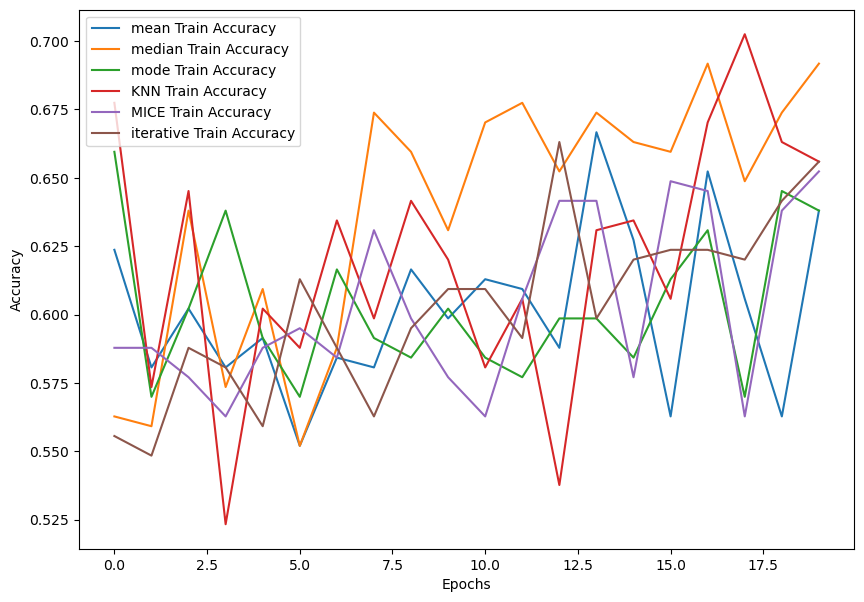

In [40]:
# Plotting train and validation accuracy
plt.figure(figsize=(10,7))
for impute_name in imputation_methods.keys():
    plt.plot(all_train_accuracies[impute_name], label=f'{impute_name} Train Accuracy')
    # plt.plot(all_val_accuracies[impute_name], label=f'{impute_name} Val Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

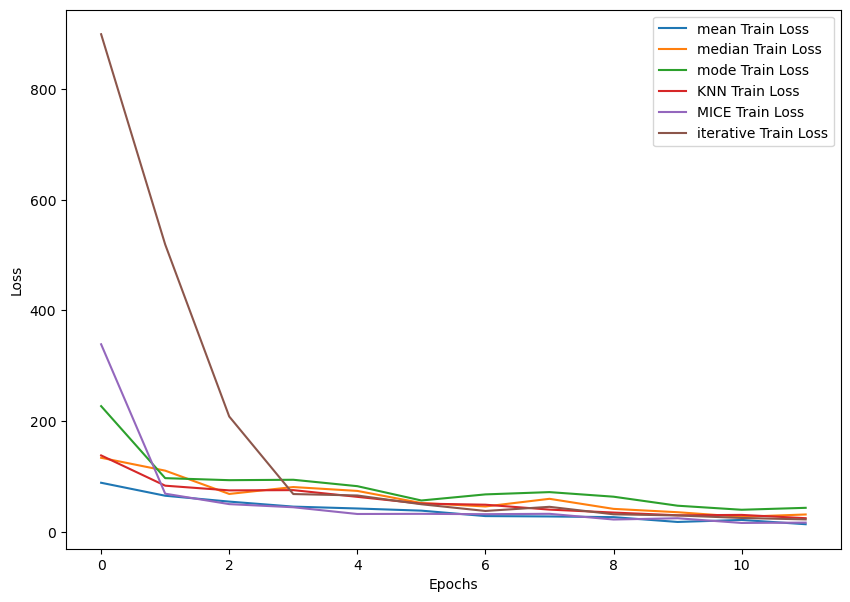

In [25]:
# Plotting train and validation loss
plt.figure(figsize=(10,7))
for impute_name in imputation_methods.keys():
    try:
        plt.plot(all_train_losses[impute_name], label=f'{impute_name} Train Loss')
        # plt.plot(all_val_losses[impute_name], label=f'{impute_name} Val Loss')
    except KeyError:
        print(f"No data for {impute_name} in train/val losses")

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 7. evaluate on the test set

In [26]:
# Print metrics
for impute_name in imputation_methods.keys():
    try:
        print(f'For {impute_name} imputation:')
        print('Confusion Matrix:')
        print(all_val_metrics['confusion_matrix'][impute_name])
        print('Classification Report:')
        print(all_val_metrics['classification_report'][impute_name])
        print()
    except KeyError:
        print(f"No data for {impute_name} in validation metrics")

For mean imputation:
Confusion Matrix:
[[0 5]
 [0 5]]
Classification Report:
{'False': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 5}, 'True': {'precision': 0.5, 'recall': 1.0, 'f1-score': 0.6666666666666666, 'support': 5}, 'accuracy': 0.5, 'macro avg': {'precision': 0.25, 'recall': 0.5, 'f1-score': 0.3333333333333333, 'support': 10}, 'weighted avg': {'precision': 0.25, 'recall': 0.5, 'f1-score': 0.3333333333333333, 'support': 10}}

For median imputation:
Confusion Matrix:
[[0 5]
 [0 5]]
Classification Report:
{'False': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 5}, 'True': {'precision': 0.5, 'recall': 1.0, 'f1-score': 0.6666666666666666, 'support': 5}, 'accuracy': 0.5, 'macro avg': {'precision': 0.25, 'recall': 0.5, 'f1-score': 0.3333333333333333, 'support': 10}, 'weighted avg': {'precision': 0.25, 'recall': 0.5, 'f1-score': 0.3333333333333333, 'support': 10}}

For mode imputation:
Confusion Matrix:
[[0 5]
 [0 5]]
Classification Report:
{'False': {